In [1]:
# %load_ext autoreload
# %autoreload 2

import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp  # noqa: E402
import jax.random as jrandom  # noqa: E402

import galsim  # noqa: E402

In [6]:
gal_size = 0.8
psf_fwhm = 0.9

gal = galsim.Gaussian(fwhm=gal_size)
# gal = galsim.DeVaucouleurs(half_light_radius=gal_size)
gal = gal.shear(e1=-0.2, e2=0.1)
psf = galsim.Gaussian(fwhm=psf_fwhm)

img = galsim.Convolve(
    gal, psf
).shift(-0.1, 0.1).drawImage(scale=0.2, nx=51, ny=51)

img_gal_only = gal.shift(-0.1, 0.1).drawImage(scale=0.2, nx=51, ny=51, method="no_pixel")

img_psf_only = psf.drawImage(scale=0.2, nx=51, ny=51)

In [7]:
from ngmix.flags import get_flags_str
from admom_jax import admom
from admom_core import Obs, fwhm_to_T, gen_guess_admom

cenonly = False
cen = (img.array.shape[0] - 1) / 2

print("gal T:", fwhm_to_T(gal_size))

obs_psf = obs = Obs(
    image=img_psf_only.array,
    weight=jnp.ones_like(img.array),
    cen_x=cen,
    cen_y=cen,
    dudx=0.2,
    dudy=0.0,
    dvdx=0.0,
    dvdy=0.2,
)

res_psf = admom(
    [obs_psf],
    gen_guess_admom(jrandom.key(0), guess_T=0.7, jac_scale=0, rng_scale=0),
    unroll=10,
    cenonly=cenonly,
    maxitr=200,
)

print("psf T trueT:", res_psf[0][4], fwhm_to_T(psf_fwhm))

obs = Obs(
    image=img.array,
    weight=jnp.ones_like(img.array),
    cen_x=cen,
    cen_y=cen,
    dudx=0.2,
    dudy=0.0,
    dvdx=0.0,
    dvdy=0.2,
    psf_T=res_psf[0][4],
)

res = admom(
    [obs],
    gen_guess_admom(jrandom.key(0), guess_T=0.7, jac_scale=0, rng_scale=0),
    unroll=10,
    cenonly=cenonly,
    maxitr=200,
)

obs_gal_only = Obs(
    image=img_gal_only.array,
    weight=jnp.ones_like(img_gal_only.array),
    cen_x=cen,
    cen_y=cen,
    dudx=0.2,
    dudy=0.0,
    dvdx=0.0,
    dvdy=0.2,
    psf_T=0.0,
)

res_gal_only = admom(
    [obs_gal_only],
    gen_guess_admom(jrandom.key(0), guess_T=0.7, jac_scale=0, rng_scale=0),
    unroll=10,
    cenonly=cenonly,
    maxitr=200,
)

print("gal+psf  [v,y,e1,e2,T,f] flags:", res[0], f"'{get_flags_str(res[1])}'")
print("gal only [v,y,e1,e2,T,f] flags:", res_gal_only[0], f"'{get_flags_str(res[1])}'")

gal T: 0.2308312065422342
psf T trueT: 0.2988629778548025 0.2921457457800151
gal+psf  [v,y,e1,e2,T,f] flags: [ 0.09999829 -0.09999858 -0.2000048   0.1000072   0.23681048  0.50001348] ''
gal only [v,y,e1,e2,T,f] flags: [ 0.09999886 -0.09999928 -0.19999803  0.09999902  0.23683248  0.50001008] ''


In [47]:
import numpy as np
import tqdm

gal = galsim.Gaussian(fwhm=1e-6)
# gal = galsim.Exponential(half_light_radius=0.5)
gal = gal.shear(e1=-0.2, e2=0.1)

nse = 7e-3
# nse = 1e-6

moms = []
flags = []
for _ in tqdm.tqdm(range(500)):
    rng = np.random.RandomState()

    obs_list = []
    for i, psf_fwhm in enumerate([0.9, 0.7, 1.1]):
        psf = galsim.Gaussian(fwhm=psf_fwhm)
        img = galsim.Convolve(
            gal,
            psf,
        ).shift(-0.1, 0.1).drawImage(scale=0.2, nx=51, ny=51)

        img_psf_only = psf.drawImage(scale=0.2, nx=51, ny=51)
        obs_psf = Obs(
            image=img_psf_only.array,
            weight=jnp.ones_like(img_psf_only.array) * 1e12,
            cen_x=cen,
            cen_y=cen,
            dudx=0.2,
            dudy=0.0,
            dvdx=0.0,
            dvdy=0.2,
        )
        res_psf = admom(
            [obs_psf],
            gen_guess_admom(jrandom.key(0), guess_T=0.7, jac_scale=0, rng_scale=0),
            unroll=10,
            cenonly=cenonly,
            maxitr=200,
        )

        obs_list.append(Obs(
            image=img.array * (i + 1) + rng.normal(loc=0, scale=nse, size=img.array.shape),
            weight=jnp.ones_like(img.array) / nse**2,
            cen_x=cen,
            cen_y=cen,
            dudx=0.2,
            dudy=0.0,
            dvdx=0.0,
            dvdy=0.2,
            psf_T=res_psf[0][4],
            psf=obs_psf,
        ))

    res = admom(
        obs_list,
        gen_guess_admom(jrandom.key(0), n_obs=len(obs_list), guess_T=0.7, jac_scale=0, rng_scale=0),
        unroll=True,
        cenonly=cenonly,
        maxitr=25,
    )
    if res[1] != 0:
        print("failure:", f"'{get_flags_str(res[1])}'")
    else:
        moms.append(res[0].to_device(None))
        flags.append(res[1])

# print("gal+psf  [v,y,e1,e2,T,f0,...,fn] flags:", res[0], f"'{get_flags_str(res[1])}'")

moms = np.array(moms)
print("moms.shape", moms.shape)

100%|██████████| 500/500 [00:13<00:00, 37.88it/s]

moms.shape (500, 8)


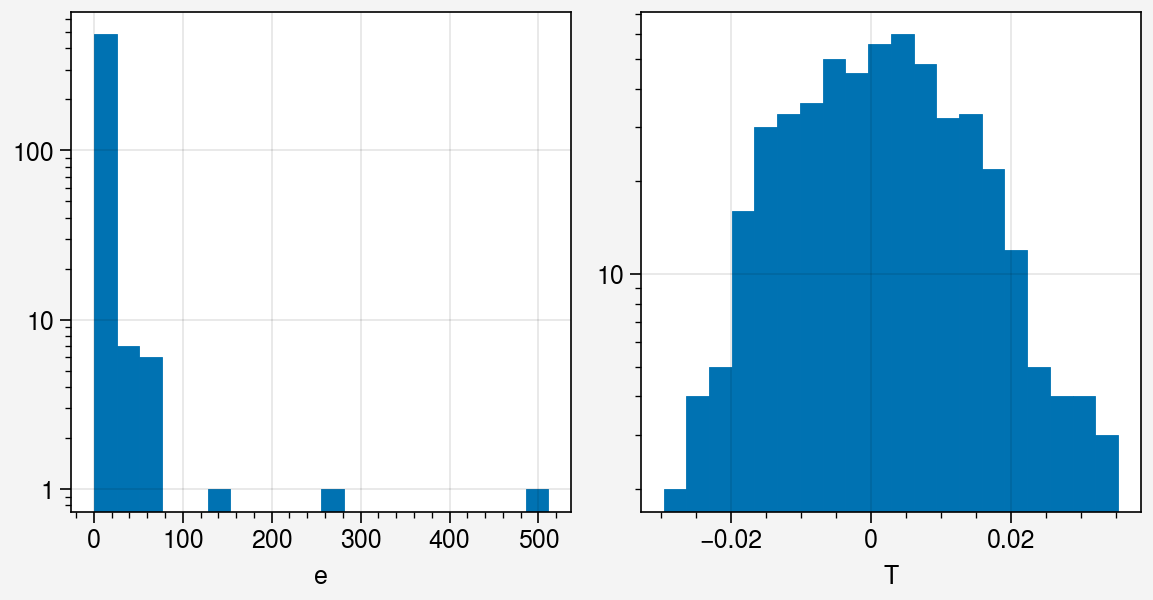

In [48]:
import ultraplot as uplt
import numpy as np

fig, axs = uplt.subplots(nrows=1, ncols=2, share=0)

# axs[0].hist(np.log10(1.0 + np.sqrt(moms[:, 2]**2 + moms[:, 3]**2)), bins=20, log=True)
# axs[0].format(xlabel="log10[1+ e]")

evals = np.sqrt(moms[:, 2]**2 + moms[:, 3]**2)
axs[0].hist(evals, bins=20, log=True)
axs[0].format(xlabel="e")

axs[1].hist(moms[:, 4], bins=20, log=True)
axs[1].format(xlabel="T")

In [29]:
import numpy as np

import ngmix

from admom_core import obs_to_ngmix_obs
from metadetect.fitting import fit_mbobs_gauss
from metadetect.procflags import get_procflags_str


In [32]:
%%time

mbobs = ngmix.MultiBandObsList()
for obs in obs_list:
    ng_obs = obs_to_ngmix_obs(obs)
    print("s/n:", ng_obs.get_s2n())
    ol = ngmix.ObsList()
    ol.append(obs_to_ngmix_obs(obs))
    mbobs.append(ol)

res = fit_mbobs_gauss(mbobs=mbobs, bmask_flags=0, rng=np.random.RandomState(42))

print(
    "mbobs    [e1,e2] T flags:",
    np.array(ngmix.shape.g1g2_to_e1e2(*res["gauss_g"][0])),
    res["gauss_T"][0],
    f"'{get_procflags_str(res['gauss_flags'])}'"
)


s/n: 2.8210892656188964
s/n: 5.418372757728079
s/n: 6.997508866023284
mbobs    [e1,e2] T flags: [-0.11488905  0.0117069 ] 0.3274981021263068 ''
CPU times: user 19.1 ms, sys: 2.81 ms, total: 21.9 ms
Wall time: 22.8 ms


In [84]:
from ngmix.shape import g1g2_to_e1e2
from ngmix.priors.shape import GPriorBA

gpr = GPriorBA(0.3, np.random.RandomState())
gvals = gpr.sample2d(10000)

evals = g1g2_to_e1e2(gvals[0], gvals[1])

(0.4081002002313441, 0.4114678950301477)

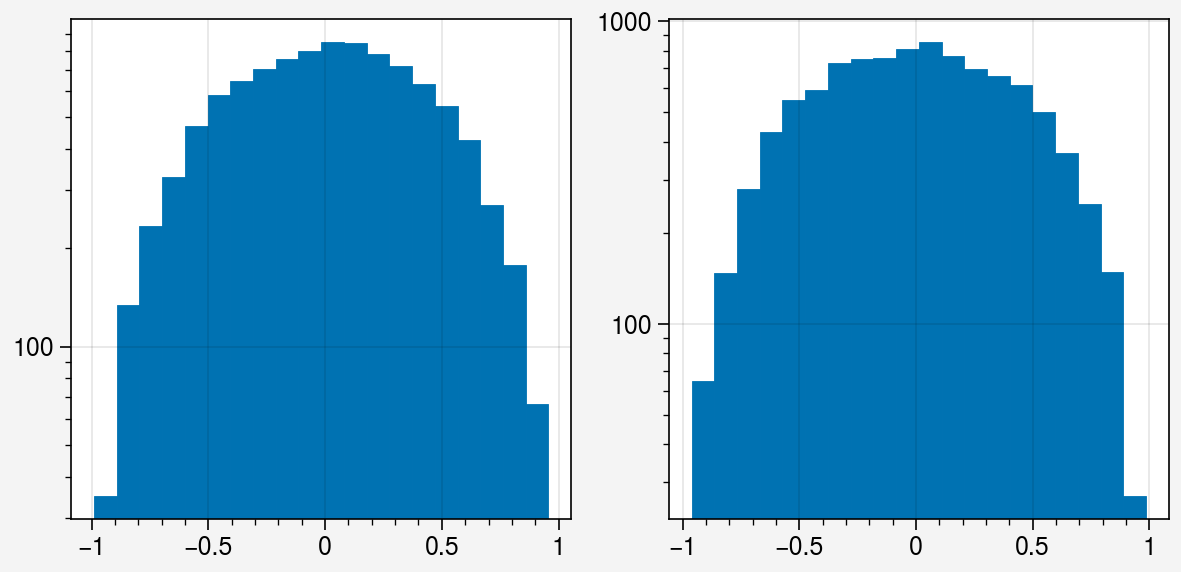

In [85]:
fig, axs = uplt.subplots(nrows=1, ncols=2, share=0)

axs[0].hist(evals[0], bins=20, log=True)
axs[1].hist(evals[1], bins=20, log=True)
np.std(evals[0]), np.std(evals[1])

0.14459675790029675 0.05961236867477975 0.41226628826549516


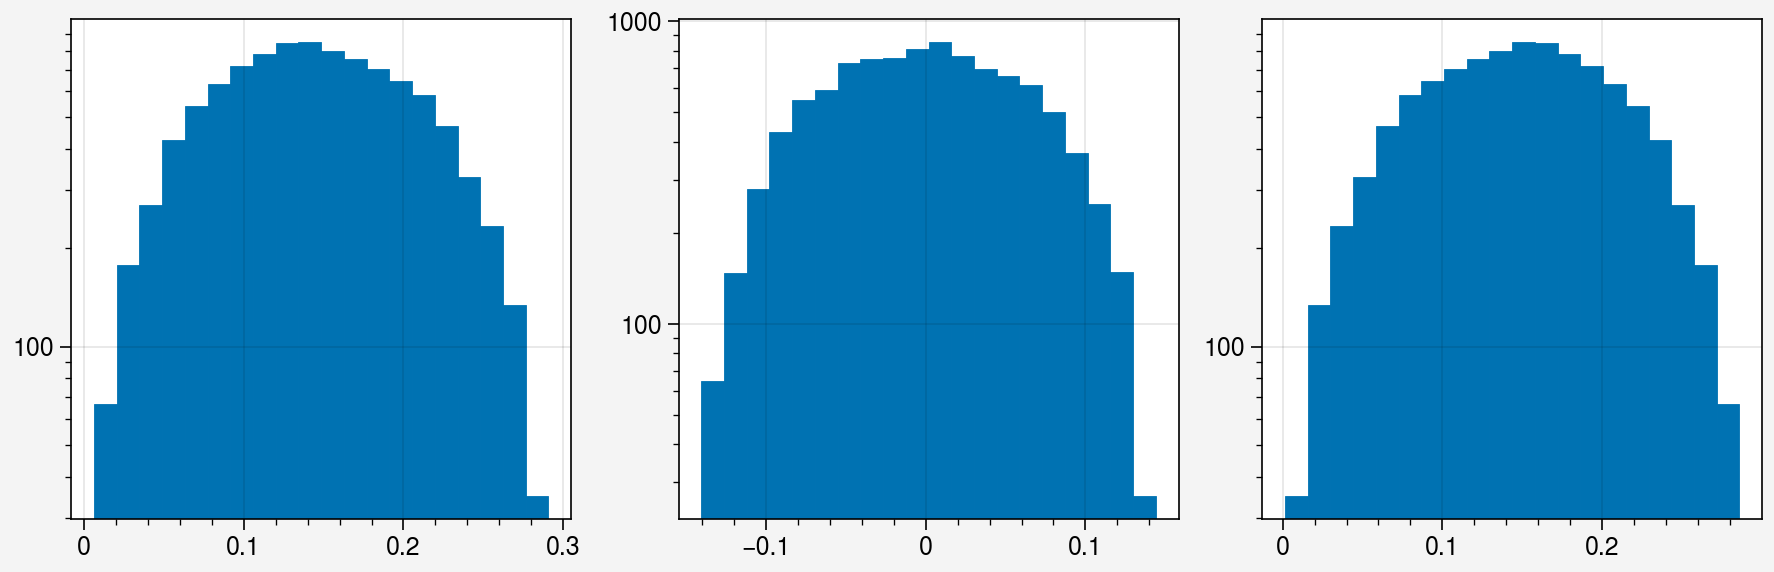

In [100]:
import ngmix.moments

irr, irc, icc = ngmix.moments.e2mom(evals[0], evals[1], fwhm_to_T(0.9))

fig, axs = uplt.subplots(nrows=1, ncols=3, share=0)

axs[0].hist(irr, bins=20, log=True)
axs[1].hist(irc, bins=20, log=True)
axs[2].hist(icc, bins=20, log=True)

print(np.mean(irr), np.std(irr), np.std(irr) / np.mean(irr))

In [87]:
import scipy.stats

In [151]:
target_T_2 = fwhm_to_T(0.9) / 2.0
df = 5

psi_val = target_T_2 * (df - 2 - 1)
# psi_val = target_T_2 * (df + 2 + 1)
mn = psi_val / (df - 2 - 1)
# std = np.sqrt(2 * psi_val**2 / (df - 2 - 1) / (df - 2 - 1) / (df - 2 - 3))

print(target_T_2, mn)

0.14607287289000756 0.14607287289000756


0.14584340599319257 0.2683996235929738
0.14459675790029675 0.05961236867477975


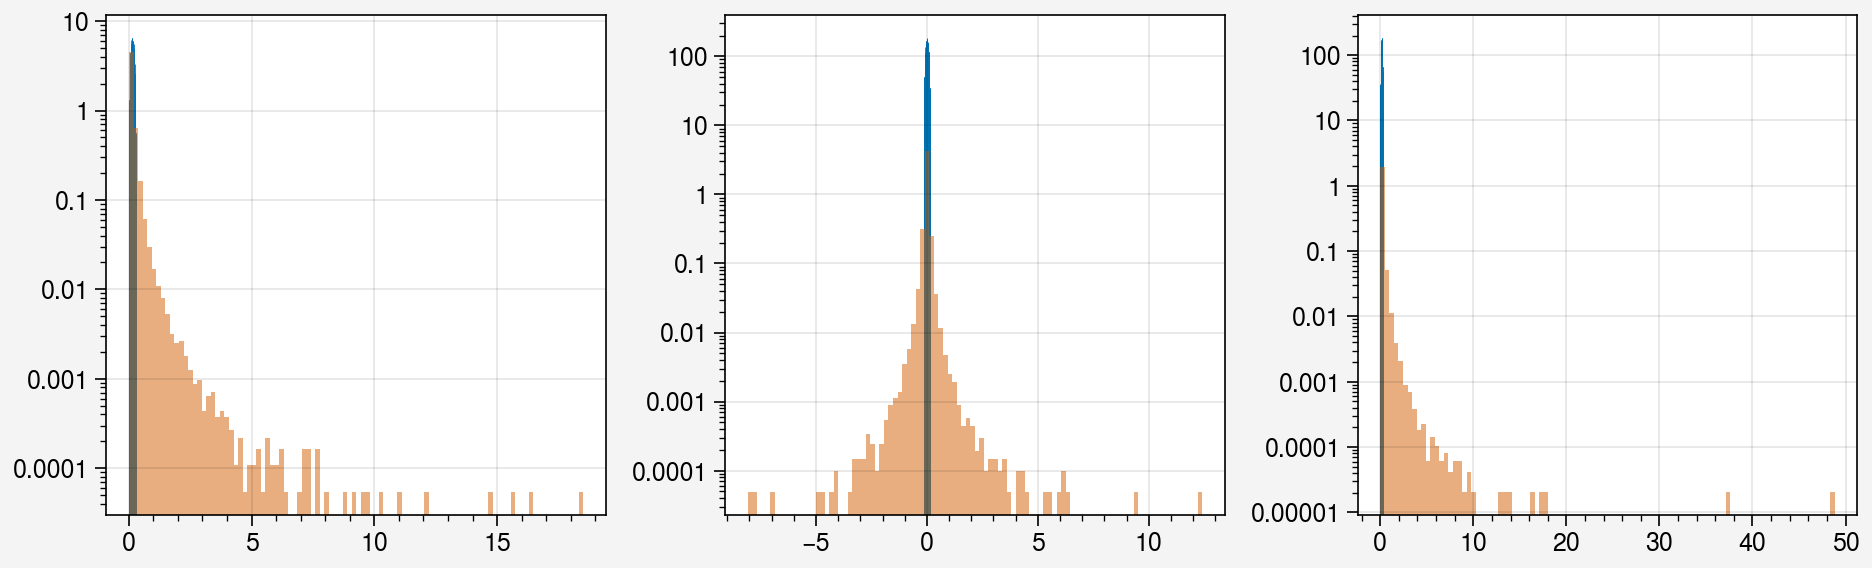

In [148]:
scale_mat = np.array(
    [[psi_val, 0.0], [0.0, psi_val]]
)

dst = scipy.stats.invwishart(df=df, scale=scale_mat)


draws = dst.rvs(100000)
draws = np.moveaxis(draws, 0, -1)
print(np.mean(draws[0, 0, :]), np.std(draws[0, 0, :]))

irr, irc, icc = ngmix.moments.e2mom(evals[0], evals[1], fwhm_to_T(0.9))
print(np.mean(irr), np.std(irr))

fig, axs = uplt.subplots(nrows=1, ncols=3, share=0)

nb = 100
axs[0].hist(irr, bins=nb, log=True, density=True)
axs[0].hist(draws[0, 0, :], bins=nb, log=True, density=True, alpha=0.5)
axs[1].hist(irc, bins=nb, log=True)
axs[1].hist(draws[0, 1, :], bins=nb, log=True, density=True, alpha=0.5)
axs[2].hist(icc, bins=nb, log=True)
axs[2].hist(draws[1, 1, :], bins=nb, log=True, density=True, alpha=0.5);

0.4082929543107913 0.40669798363059745
0.29259568570017314 0.5407129305079027 0.2921457457800151 -0.534400433494451


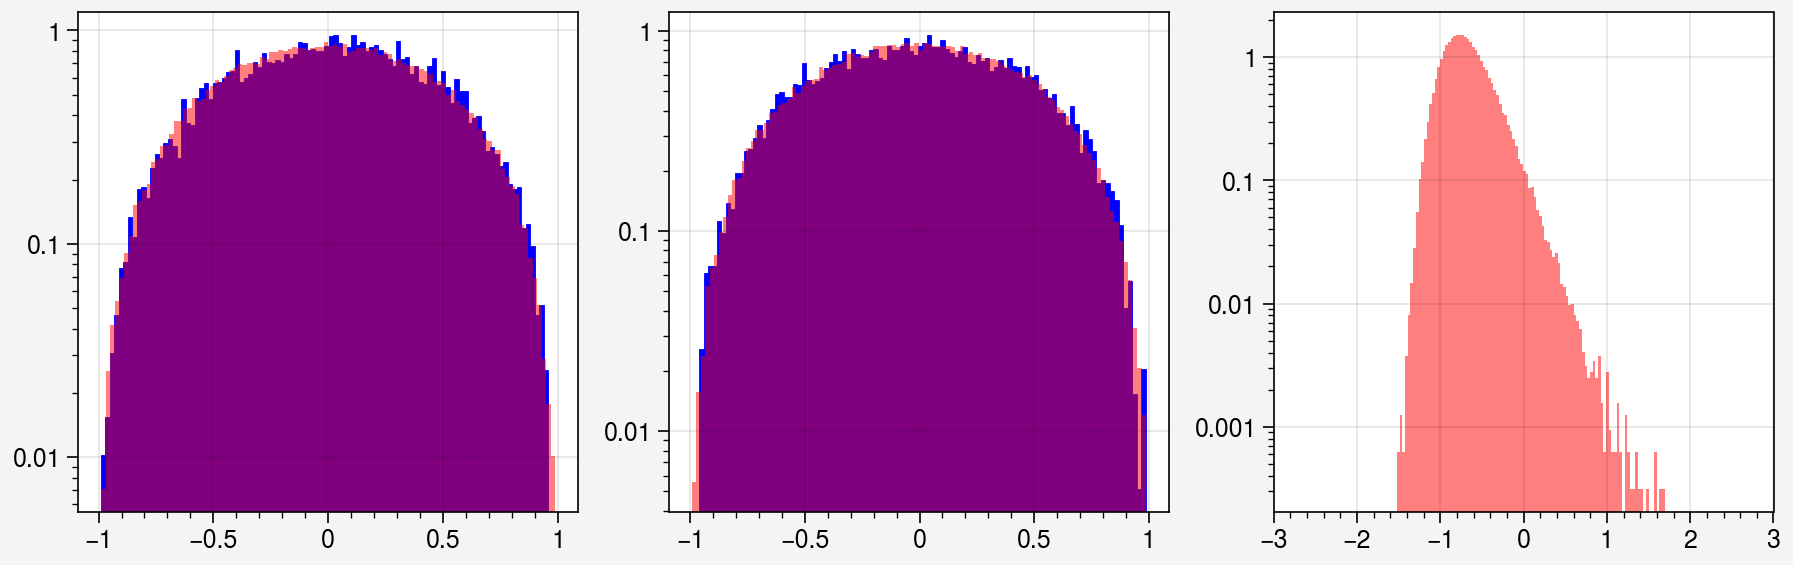

In [149]:
scale_mat = np.array(
    [[psi_val, 0.0], [0.0, psi_val]]
)

dst = scipy.stats.invwishart(df=df, scale=scale_mat)

draws = dst.rvs(100000)
draws = np.moveaxis(draws, 0, -1)

ed1, ed2, td = ngmix.moments.mom2e(draws[0, 0, :], draws[0, 1, :], draws[1, 1, :])
print(np.std(ed1), np.std(ed2))
print(np.mean(td), np.std(td), fwhm_to_T(0.9), np.log10(fwhm_to_T(0.9)))

fig, axs = uplt.subplots(nrows=1, ncols=3, share=0)

nb = 100
axs[0].hist(evals[0], bins=nb, log=True, density=True, color="blue")
axs[0].hist(ed1, bins=nb, log=True, density=True, alpha=0.5, color="red")
axs[1].hist(evals[1], bins=nb, log=True, density=True, color="blue")
axs[1].hist(ed2, bins=nb, log=True, density=True, alpha=0.5, color="red")
# axs[2].hist(tvals, bins=nb, log=True, density=True)
axs[2].hist(np.log10(td), bins=nb, log=True, density=True, alpha=0.5, color="red");
axs[2].format(xlim=(-3, 3))


0.9550545562989369